In [20]:
!pip install -q langchain langchain-google-genai langgraph rich python-dotenv pydantic typing_extensions tenacity tavily-python sqlite-utils langgraph-checkpoint-sqlite

In [21]:
# Run this cell next
import os
from rich.console import Console
from rich.panel import Panel
from rich.text import Text
from rich.markdown import Markdown
from rich.table import Table
import json, time, sqlite3, operator
from typing_extensions import Optional, Annotated, Sequence, Literal
from pydantic import BaseModel, Field
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, SystemMessage, get_buffer_string
from langgraph.graph import MessagesState, StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.types import Command
from datetime import datetime
from langchain.chat_models import init_chat_model
from IPython.display import Image, display
from langgraph.checkpoint.memory import InMemorySaver

console = Console()

# Set your Google GenAI key (or put it into Colab environment). If already set, will use it.
if not os.environ.get("GOOGLE_API_KEY"):
    # prompt (you can paste your key into the input)
    os.environ["GOOGLE_API_KEY"] = input("Enter GOOGLE_API_KEY (paste and press Enter): ").strip()

# initialize model (keeps same model name you used)
model = init_chat_model("gemini-2.5-flash-lite", model_provider="google_genai", temperature=0)


In [22]:
# Utility: date function (you already had this)
def get_today_str() -> str:
    dt = datetime.now()
    return f"{dt.strftime('%a %b')} {dt.day}, {dt.strftime('%Y')}"

# UI helpers (Rich)
def show_prompt(prompt_text: str, title: str = "Prompt", border_style: str = "blue"):
    formatted_text = Text(prompt_text)
    formatted_text.highlight_regex(r'<[^>]+>', style="bold blue")
    formatted_text.highlight_regex(r'##[^#\n]+', style="bold magenta")
    formatted_text.highlight_regex(r'###[^#\n]+', style="bold cyan")
    console.print(Panel(formatted_text, title=f"[bold green]{title}[/bold green]", border_style=border_style, padding=(1,2)))

def format_message_content(message):
    parts, tool_calls_processed = [], False
    if isinstance(message.content, str):
        parts.append(message.content)
    elif isinstance(message.content, list):
        for item in message.content:
            if item.get('type') == 'text':
                parts.append(item['text'])
            elif item.get('type') == 'tool_use':
                parts.append(f"\n🔧 Tool Call: {item['name']}")
                parts.append(f"   Args: {json.dumps(item['input'], indent=2)}")
                tool_calls_processed = True
    else:
        parts.append(str(message.content))

    if not tool_calls_processed and hasattr(message, 'tool_calls') and message.tool_calls:
        for tool_call in message.tool_calls:
            parts.append(f"\n🔧 Tool Call: {tool_call['name']}")
            parts.append(f"   Args: {json.dumps(tool_call['args'], indent=2)}")

    return "\n".join(parts)

def format_messages(messages):
    for m in messages:
        msg_type = m.__class__.__name__.replace('Message','')
        content = format_message_content(m)
        border_styles = {"Human":"blue","Ai":"green","Tool":"yellow"}
        title_icons = {"Human":" Human","Ai":" Assistant","Tool":" Tool Output"}
        console.print(Panel(content, title=title_icons.get(msg_type," Other"), border_style=border_styles.get(msg_type,"white")))


In [23]:
# Metrics + invocation helpers (silent until end)
def get_conversation_metrics(messages):
    human_msgs = [m for m in messages if m.__class__.__name__=="HumanMessage"]
    ai_msgs = [m for m in messages if m.__class__.__name__=="AIMessage"]
    return {
        "total_messages": len(messages),
        "human_count": len(human_msgs),
        "ai_count": len(ai_msgs),
        "avg_human_length": sum(len(m.content) for m in human_msgs)/max(1,len(human_msgs)),
        "avg_ai_length": sum(len(m.content) for m in ai_msgs)/max(1,len(ai_msgs)),
    }

def specificity_score(text):
    keywords = ["specific","example","detail","data","report"]
    return sum(k in text.lower() for k in keywords)/len(keywords)

def log_metrics_to_sqlite(run_id, metrics: dict):
    # optional persistence (silent)
    conn = sqlite3.connect("research_agent.sqlite")
    c = conn.cursor()
    c.execute("""CREATE TABLE IF NOT EXISTS metrics (run_id TEXT, key TEXT, value REAL)""")
    for k,v in metrics.items():
        c.execute("INSERT INTO metrics VALUES (?,?,?)", (run_id, k, float(v) if isinstance(v,(int,float)) else str(v)))
    conn.commit()
    conn.close()

def timed_invoke_model(chat_model, msgs):
    """Helper for direct model.invoke calls (not used for the graph nodes, but kept if needed)."""
    start = time.time()
    resp = chat_model.invoke(msgs)
    elapsed = round(time.time() - start, 3)
    return resp, elapsed

def run_with_metrics(run_id, scope_obj, messages_for_scope, config, return_metrics=True):
    """
    Execute the StateGraph (scope) with the provided messages list.
    Returns (result, metrics) if return_metrics True.
    Does NOT print metrics.
    """
    start = time.time()
    try:
        result = scope_obj.invoke({"messages": messages_for_scope}, config=config)
    except Exception as e:
        # safe fallback
        result = {"messages": [AIMessage(content=f"Internal error: {e}")]}
    end = time.time()
    duration = round(end - start, 3)

    # compute metrics (basic)
    metrics = {
        "run_id": run_id,
        "start_time": start,
        "end_time": end,
        "duration_sec": duration,
        "num_messages_sent": len(messages_for_scope),
        "num_ai_messages": sum(1 for m in result.get("messages",[]) if m.__class__.__name__=="AIMessage"),
        "num_human_messages": sum(1 for m in result.get("messages",[]) if m.__class__.__name__=="HumanMessage")
    }

    # optional persist
    try:
        log_metrics_to_sqlite(run_id, metrics)
    except Exception:
        pass

    if return_metrics:
        return result, metrics
    else:
        # legacy printing (not used in our interactive flow)
        print("Metrics:", metrics)
        return result


In [24]:
clarify_with_user_instructions = """
These are the messages that have been exchanged so far from the user asking for the report:
<Messages>
{messages}
</Messages>

Today's date is {date}.

IMPORTANT (date): In the JSON you return include a field "date" set to the current date EXACTLY as "{date}".
Do not output extra text outside the JSON. The model's JSON must include these keys:
"need_clarification": boolean,
"question": "<question to ask the user to clarify the report scope>",
"verification": "<verification message we will use to start research>",
"date": "<the current date as provided above>"

If you need to ask a clarifying question, return:
{{"need_clarification": true, "question":"<your question>", "verification":"", "date":"{date}"}}

If you do not need clarification, return:
{{"need_clarification": false, "question":"", "verification":"<acknowledgement>","date":"{date}"}}
"""

transform_messages_into_research_topic_prompt = """
You will be given messages exchanged so far:
<Messages>
{messages}
</Messages>

Today's date is {date}.

Return a JSON object with two keys:
- "research_brief": a single, specific, actionable research brief (use the first person).
- "date": the current date EXACTLY as "{date}".

Example:
{{"research_brief":"I want X, Y, Z...", "date":"{date}"}}
"""


In [25]:
clarify_with_user_instructions = """
These are the messages that have been exchanged so far from the user asking for the report:
<Messages>
{messages}
</Messages>

Today's date is {date}.

IMPORTANT (date): In the JSON you return include a field "date" set to the current date EXACTLY as "{date}".
Do not output extra text outside the JSON. The model's JSON must include these keys:
"need_clarification": boolean,
"question": "<question to ask the user to clarify the report scope>",
"verification": "<verification message we will use to start research>",
"date": "<the current date as provided above>"

If you need to ask a clarifying question, return:
{{"need_clarification": true, "question":"<your question>", "verification":"", "date":"{date}"}}

If you do not need clarification, return:
{{"need_clarification": false, "question":"", "verification":"<acknowledgement>","date":"{date}"}}
"""

# show prompt header for reference
show_prompt(clarify_with_user_instructions.format(messages="(conversation buffer)", date=get_today_str()), "Clarify with User Instructions")

╭──────────────────────────────────────── Clarify with User Instructions ─────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│  These are the messages that have been exchanged so far from the user asking for the report:                    │
│  <Messages>                                                                                                     │
│  (conversation buffer)                                                                                          │
│  </Messages>                                                                                                    │
│                                                                                                                 │
│  Today's date is Wed Sep 17, 2025.                                                                              │
│                                                                                                                 │
│  IMPORTANT (date): In the JSON you return include a field "date" set to the current date EXACTLY as "Wed Sep    │
│  17, 2025".                                                                                                     │
│  Do not output extra text outside the JSON. The model's JSON must include these keys:                           │
│  "need_clarification": boolean,                                                                                 │
│  "question": "<question to ask the user to clarify the report scope>",                                          │
│  "verification": "<verification message we will use to start research>",                                        │
│  "date": "<the current date as provided above>"                                                                 │
│                                                                                                                 │
│  If you need to ask a clarifying question, return:                                                              │
│  {"need_clarification": true, "question":"<your question>", "verification":"", "date":"Wed Sep 17, 2025"}       │
│                                                                                                                 │
│  If you do not need clarification, return:                                                                      │
│  {"need_clarification": false, "question":"", "verification":"<acknowledgement>","date":"Wed Sep 17, 2025"}     │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [26]:
class AgentInputState(MessagesState): pass

class AgentState(MessagesState):
    research_brief: Optional[str]
    supervisor_messages: Annotated[Sequence[BaseMessage], add_messages]
    raw_notes: Annotated[list[str], operator.add] = []
    notes: Annotated[list[str], operator.add] = []
    final_report: str = ""

class ClarifyWithUser(BaseModel):
    need_clarification: bool = Field(...)
    question: str = Field(...)
    verification: str = Field(...)

class ResearchQuestion(BaseModel):
    research_brief: str = Field(...)


In [28]:
transform_messages_into_research_topic_prompt = """
You will be given messages exchanged so far:
<Messages>
{messages}
</Messages>

Today's date is {date}.

Return a JSON object with two keys:
- "research_brief": a single, specific, actionable research brief (use the first person).
- "date": the current date EXACTLY as "{date}".

Example:
{{"research_brief":"I want X, Y, Z...", "date":"{date}"}}
"""

# IMPORTANT: nodes no longer display metrics in the node functions.
def clarify_with_user(state: AgentState) -> Command[Literal["write_research_brief", "__end__"]]:
    structured_output_model = model.with_structured_output(ClarifyWithUser)

    # Provide the date explicitly as system instruction so model sees it (and we also prepend it below)
    system_msg = SystemMessage(content=f"Date instruction: When responding, start your assistant message with a line exactly 'Date: {get_today_str()}'.")

    # Human prompt includes conversation buffer and date
    user_prompt = HumanMessage(content=clarify_with_user_instructions.format(
        messages=get_buffer_string(messages=state["messages"]),
        date=get_today_str()
    ))

    # Invoke model (structured output)
    response = structured_output_model.invoke([system_msg, user_prompt])

    # Build the AI message content starting with the date (guaranteed)
    if response.need_clarification:
        ai_text = f"Date: {get_today_str()}\n{response.question}"
        return Command(goto=END, update={"messages": [AIMessage(content=ai_text)]})
    else:
        ai_text = f"Date: {get_today_str()}\n{response.verification}"
        return Command(goto="write_research_brief", update={"messages": [AIMessage(content=ai_text)]})

def write_research_brief(state: AgentState):
    structured_output_model = model.with_structured_output(ResearchQuestion)

    system_msg = SystemMessage(content=f"Date instruction: When responding, start your assistant message with a line exactly 'Date: {get_today_str()}'.")

    user_prompt = HumanMessage(content=transform_messages_into_research_topic_prompt.format(
        messages=get_buffer_string(state.get("messages", [])),
        date=get_today_str()
    ))

    response = structured_output_model.invoke([system_msg, user_prompt])

    # Ensure research brief starts with date
    research_with_date = f"Date: {get_today_str()}\n{response.research_brief}"

    return {
        "research_brief": research_with_date,
        "supervisor_messages": [HumanMessage(content=f"{research_with_date}.")]
    }

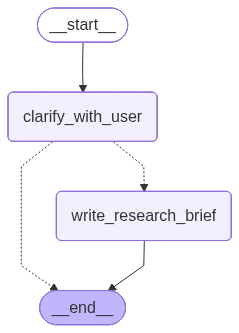

In [29]:
deep_researcher_builder = StateGraph(AgentState, input_schema=AgentInputState)
deep_researcher_builder.add_node("clarify_with_user", clarify_with_user)
deep_researcher_builder.add_node("write_research_brief", write_research_brief)
deep_researcher_builder.add_edge(START, "clarify_with_user")
deep_researcher_builder.add_edge("write_research_brief", END)

# Use an in-memory saver for demo; persistent option available
checkpointer = InMemorySaver()
scope = deep_researcher_builder.compile(checkpointer=checkpointer)

# visualize graph (optional, will render in notebook)
display(Image(scope.get_graph(xray=True).draw_mermaid_png()))


In [30]:
# conversation state (keep these global in your notebook)
thread = {"configurable": {"thread_id": "chatbot_001"}}
conversation_history = []   # list[BaseMessage]
metrics_log = []            # list[dict]

def run_research_agent_turn(user_text: str):
    """
    Run one user turn in the notebook. Returns the scope result.
    Metrics are collected and appended to metrics_log silently.
    """
    human_msg = HumanMessage(content=user_text)
    # Append user message into conversation buffer
    conversation_history.append(human_msg)

    # Build messages to send to the StateGraph (we pass the whole conversation history)
    messages_for_scope = conversation_history.copy()

    # Run the graph (silent metrics returned)
    result, run_metrics = run_with_metrics(
        run_id=f"turn_{len(metrics_log)+1}",
        scope_obj=scope,
        messages_for_scope=messages_for_scope,
        config=thread,
        return_metrics=True
    )

    # attach a readable timestamp
    run_metrics["turn_timestamp"] = get_today_str()
    metrics_log.append(run_metrics)

    # Display assistant messages (these come from the graph nodes)
    format_messages(result.get('messages', []))

    # If a research brief was produced by the workflow, display it as markdown
    if "research_brief" in result:
        console.print("\n[bold blue]🔹 Research Brief Generated:[/bold blue]")
        display(Markdown(result["research_brief"]))

    # Append AI messages from this result into conversation_history so next turn includes them
    ai_msgs = [m for m in result.get('messages', []) if isinstance(m, AIMessage)]
    conversation_history.extend(ai_msgs)

    return result


In [31]:
console.print(f"[bold green]Research Agent Chatbot started on {get_today_str()}[/bold green]")
console.print("[bold green]Type 'exit' or 'quit' to end the chat and show metrics.[/bold green]\n")

while True:
    user_text = input("You: ").strip()
    if user_text.lower() in ("exit","quit"):
        console.print("[bold red]Chatbot session ended.[/bold red]\n")
        break

    # show date in the notebook UI (optional)
    console.print(f"[bold cyan]Date: {get_today_str()}[/bold cyan]")

    # Run one turn
    _ = run_research_agent_turn(user_text)

# After the loop ends, show the metrics summary once
console.print("\n[bold magenta]📊 Session Metrics Summary (all turns)[/bold magenta]")

# print per-turn metrics
for i, m in enumerate(metrics_log, 1):
    console.print(f"\n[bold yellow]Turn {i} Metrics:[/bold yellow]")
    for k, v in m.items():
        console.print(f"{k}: {v}")

# Aggregate summary (optional)
if metrics_log:
    total_duration = sum(m.get("duration_sec",0) for m in metrics_log)
    avg_duration = round(total_duration / len(metrics_log), 3)
    total_turns = len(metrics_log)
    console.print(f"\n[bold green]Total turns:[/bold green] {total_turns}")
    console.print(f"[bold green]Total duration (s):[/bold green] {round(total_duration,3)}")
    console.print(f"[bold green]Average duration (s):[/bold green] {avg_duration}")


Research Agent Chatbot started on Wed Sep 17, 2025

Type 'exit' or 'quit' to end the chat and show metrics.

You: best cake in bangalore


Date: Wed Sep 17, 2025

╭────────────────────────────────────────────────────  Human ─────────────────────────────────────────────────────╮
│ best cake in bangalore                                                                                          │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────────────────────────  Other ─────────────────────────────────────────────────────╮
│ Date: Wed Sep 17, 2025                                                                                          │
│ What kind of report are you looking for? Are you looking for a list of the best cake shops in Bangalore, or     │
│ perhaps a recipe for a cake that is popular in Bangalore?                                                       │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

You: │ best bakeries with chocolate blueberry cake   


Date: Wed Sep 17, 2025

╭────────────────────────────────────────────────────  Human ─────────────────────────────────────────────────────╮
│ best cake in bangalore                                                                                          │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────────────────────────  Other ─────────────────────────────────────────────────────╮
│ Date: Wed Sep 17, 2025                                                                                          │
│ What kind of report are you looking for? Are you looking for a list of the best cake shops in Bangalore, or     │
│ perhaps a recipe for a cake that is popular in Bangalore?                                                       │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────────────────────────  Human ─────────────────────────────────────────────────────╮
│ │ best bakeries with chocolate blueberry cake                                                                   │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────────────────────────  Other ─────────────────────────────────────────────────────╮
│ Date: Wed Sep 17, 2025                                                                                          │
│ I will search for bakeries with chocolate blueberry cake in Bangalore.                                          │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

🔹 Research Brief Generated:

Date: Wed Sep 17, 2025 I want to find the best bakeries in Bangalore that offer chocolate blueberry cake.

You: Here are the prices for the cakes at the bakeries in Bangalore that offer or are known for a chocolate            blueberry cake:  Cakeday Bakehouse: Their chocolate blueberry cake is priced at Rs. 449.  Aubree Haute            Chocolaterie: The Eggless Blueberry cake is priced at ₹ 940.  SMOOR: The Perfect Blueberry Cheesecake is priced   at ₹ 1,533 for a half kilogram. The price of their blueberry crumble cake is not available online.  Liliyum       Patisserie: Their Blueberry Tea Cake is priced at Rs. 675, and their celebration Blueberry cake ranges from Rs. 1,195 to Rs. 3,295.  Please note that prices can vary based on size and customization.


Date: Wed Sep 17, 2025

╭────────────────────────────────────────────────────  Human ─────────────────────────────────────────────────────╮
│ best cake in bangalore                                                                                          │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────────────────────────  Other ─────────────────────────────────────────────────────╮
│ Date: Wed Sep 17, 2025                                                                                          │
│ What kind of report are you looking for? Are you looking for a list of the best cake shops in Bangalore, or     │
│ perhaps a recipe for a cake that is popular in Bangalore?                                                       │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────────────────────────  Human ─────────────────────────────────────────────────────╮
│ │ best bakeries with chocolate blueberry cake                                                                   │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────────────────────────  Other ─────────────────────────────────────────────────────╮
│ Date: Wed Sep 17, 2025                                                                                          │
│ I will search for bakeries with chocolate blueberry cake in Bangalore.                                          │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────────────────────────  Human ─────────────────────────────────────────────────────╮
│ Here are the prices for the cakes at the bakeries in Bangalore that offer or are known for a chocolate          │
│ blueberry cake:  Cakeday Bakehouse: Their chocolate blueberry cake is priced at Rs. 449.  Aubree Haute          │
│ Chocolaterie: The Eggless Blueberry cake is priced at ₹ 940.  SMOOR: The Perfect Blueberry Cheesecake is priced │
│ at ₹ 1,533 for a half kilogram. The price of their blueberry crumble cake is not available online.  Liliyum     │
│ Patisserie: Their Blueberry Tea Cake is priced at Rs. 675, and their celebration Blueberry cake ranges from Rs. │
│ 1,195 to Rs. 3,295.  Please note that prices can vary based on size and customization.                          │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────────────────────────  Other ─────────────────────────────────────────────────────╮
│ Date: Wed Sep 17, 2025                                                                                          │
│ I have provided the prices for chocolate blueberry cakes at various bakeries in Bangalore. Is there anything    │
│ else I can help you with regarding this?                                                                        │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

🔹 Research Brief Generated:

Date: Wed Sep 17, 2025 I want to know the most popular cake flavors in Bangalore.

You: free from artifical coloring 


Date: Wed Sep 17, 2025

╭────────────────────────────────────────────────────  Human ─────────────────────────────────────────────────────╮
│ best cake in bangalore                                                                                          │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────────────────────────  Other ─────────────────────────────────────────────────────╮
│ Date: Wed Sep 17, 2025                                                                                          │
│ What kind of report are you looking for? Are you looking for a list of the best cake shops in Bangalore, or     │
│ perhaps a recipe for a cake that is popular in Bangalore?                                                       │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────────────────────────  Human ─────────────────────────────────────────────────────╮
│ │ best bakeries with chocolate blueberry cake                                                                   │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────────────────────────  Other ─────────────────────────────────────────────────────╮
│ Date: Wed Sep 17, 2025                                                                                          │
│ I will search for bakeries with chocolate blueberry cake in Bangalore.                                          │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────────────────────────  Human ─────────────────────────────────────────────────────╮
│ Here are the prices for the cakes at the bakeries in Bangalore that offer or are known for a chocolate          │
│ blueberry cake:  Cakeday Bakehouse: Their chocolate blueberry cake is priced at Rs. 449.  Aubree Haute          │
│ Chocolaterie: The Eggless Blueberry cake is priced at ₹ 940.  SMOOR: The Perfect Blueberry Cheesecake is priced │
│ at ₹ 1,533 for a half kilogram. The price of their blueberry crumble cake is not available online.  Liliyum     │
│ Patisserie: Their Blueberry Tea Cake is priced at Rs. 675, and their celebration Blueberry cake ranges from Rs. │
│ 1,195 to Rs. 3,295.  Please note that prices can vary based on size and customization.                          │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────────────────────────  Other ─────────────────────────────────────────────────────╮
│ Date: Wed Sep 17, 2025                                                                                          │
│ I have provided the prices for chocolate blueberry cakes at various bakeries in Bangalore. Is there anything    │
│ else I can help you with regarding this?                                                                        │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────────────────────────  Human ─────────────────────────────────────────────────────╮
│ free from artifical coloring                                                                                    │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────────────────────────  Other ─────────────────────────────────────────────────────╮
│ Date: Wed Sep 17, 2025                                                                                          │
│ Are you looking for bakeries that are free from artificial coloring, or are you looking for chocolate blueberry │
│ cakes that are free from artificial coloring?                                                                   │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

🔹 Research Brief Generated:

Date: Wed Sep 17, 2025 I want to know the most popular cake flavors in Bangalore.

You: exit


Chatbot session ended.

📊 Session Metrics Summary (all turns)

Turn 1 Metrics:

run_id: turn_1

start_time: 1758129947.4118707

end_time: 1758129948.4330037

duration_sec: 1.021

num_messages_sent: 1

num_ai_messages: 1

num_human_messages: 1

turn_timestamp: Wed Sep 17, 2025

Turn 2 Metrics:

run_id: turn_2

start_time: 1758129991.092389

end_time: 1758129992.526602

duration_sec: 1.434

num_messages_sent: 3

num_ai_messages: 2

num_human_messages: 2

turn_timestamp: Wed Sep 17, 2025

Turn 3 Metrics:

run_id: turn_3

start_time: 1758130084.5426457

end_time: 1758130086.0485315

duration_sec: 1.506

num_messages_sent: 6

num_ai_messages: 3

num_human_messages: 3

turn_timestamp: Wed Sep 17, 2025

Turn 4 Metrics:

run_id: turn_4

start_time: 1758130210.4592488

end_time: 1758130211.07089

duration_sec: 0.612

num_messages_sent: 10

num_ai_messages: 4

num_human_messages: 4

turn_timestamp: Wed Sep 17, 2025

Total turns: 4

Total duration (s): 4.573

Average duration (s): 1.143